In [2]:
from __future__ import print_function, division

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from load_dataset import BangladeshDataset
from utils import torch_to_im_show
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
%matplotlib inline

In [3]:
train_data_dir = '/home/echartock03/data/bangladesh_vis_jpgs/train/'
val_data_dir = '/home/echartock03/data/bangladesh_vis_jpgs/train/'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train_fake.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid_fake.csv'


train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir)
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir)

image_datasets = {'train': train_dataset, 'val': val_dataset}

0 (500, 500, 3) ()
1 (500, 500, 3) ()
2 (500, 500, 3) ()
3 (500, 500, 3) ()


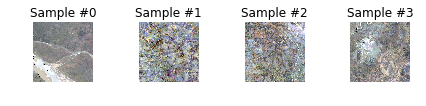

In [4]:
# visualize a few images from training set

fig = plt.figure()

for i in range(len(image_datasets['train'])):
    image, label = image_datasets['train'][i]

    print(i, np.array(image).shape, label.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

    if i == 3:
        plt.show()
        break

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data_dir = '/home/echartock03/data/bangladesh_vis_jpgs/train/'
val_data_dir = '/home/echartock03/data/bangladesh_vis_jpgs/train/'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train_fake.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid_fake.csv'


train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir,
                                           transform=data_transforms['train'])
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir,
                                           transform=data_transforms['val'])

image_datasets = {'train': train_dataset, 'val': val_dataset}

dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [6]:
dataset_sizes

{'train': 440, 'val': 108}

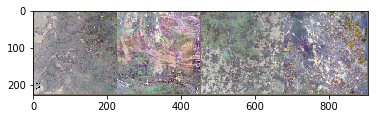

In [7]:
# visualize a random batch worth of images
images, labels = next(iter(dataloders['train']))
out = torchvision.utils.make_grid(images)
torch_to_im_show(out)

In [8]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_r2 = 0.0

    losses = {'train': [], 'val': []}
    r2s = {'train': [], 'val': []}

    for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    y_true = []
    y_pred = []
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            #scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        # running_corrects = 0

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            y_true += labels.numpy().tolist()

            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels.float())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = outputs.data
            loss = criterion(outputs, labels)

            y_pred += preds.squeeze().numpy().tolist()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.data[0]
            #running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_ro, epoch_p = pearsonr(y_pred, y_true)
        #epoch_acc = running_corrects / dataset_sizes[phase]

        losses[phase].append(epoch_loss)
        r2s[phase].append(epoch_ro)

        print('{} Loss: {:.4f} R2: {:.4f}'.format(
            phase, epoch_loss, epoch_ro))

        # deep copy the model
        if phase == 'val' and epoch_ro > best_r2:
            best_r2 = epoch_ro
            best_model_wts = model.state_dict()

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print(losses)
    print(r2s)
    print('Best R2: {:4f}'.format(best_r2))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #return model

IndentationError: expected an indented block (<ipython-input-8-a223e60c16b1>, line 11)

In [9]:
use_gpu = torch.cuda.is_available()
######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#
model_conv = torchvision.models.resnet18(pretrained=True)

######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

# 1 since we are only predicting household expenditure
model_conv.fc = nn.Linear(num_ftrs, 1)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.MSELoss()


optimizer_conv = Adam(model_conv.fc.parameters(), 1e-3)

In [10]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [11]:
#model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=2)
#def train_model(model, criterion, optimizer, num_epochs=25):
model = model_conv
optimizer = optimizer_conv
num_epochs = 2
since = time.time()

best_model_wts = model.state_dict()
best_r2 = 0.0

losses = {'train': [], 'val': []}
r2s = {'train': [], 'val': []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    y_true = []
    y_pred = []
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            #scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        # running_corrects = 0

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data
            
            y_true += labels.numpy().tolist()

            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels.float())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = outputs.data
            loss = criterion(outputs, labels)
            
            y_pred += preds.squeeze().numpy().tolist()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.data[0]
            #running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_ro, epoch_p = pearsonr(y_pred, y_true)
        #epoch_acc = running_corrects / dataset_sizes[phase]
        
        losses[phase].append(epoch_loss)
        r2s[phase].append(epoch_ro)

        print('{} Loss: {:.4f} R2: {:.4f}'.format(
            phase, epoch_loss, epoch_ro))

        # deep copy the model
        if phase == 'val' and epoch_ro > best_r2:
            best_r2 = epoch_ro
            best_model_wts = model.state_dict()

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print(losses)
print(r2s)
print('Best R2: {:4f}'.format(best_r2))

# load best model weights
model.load_state_dict(best_model_wts)
#return model

Epoch 0/1
----------
train Loss: 2123.6950 R2: -0.0020
val Loss: 1481.5434 R2: 0.0041

Epoch 1/1
----------
train Loss: 1084.5339 R2: -0.0887
val Loss: 914.0271 R2: -0.0532

Training complete in 1m 28s
{'train': [2123.69503735629, 1084.5339035727761], 'val': [1481.5433646308052, 914.0271428426107]}
{'train': [-0.0020499472508591216, -0.088731504849063905], 'val': [0.0040549647545047385, -0.053189551980302591]}
Best R2: 0.004055


NameError: global name 'imshow' is not defined

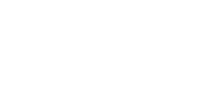

In [13]:
from utils import visualize_model
visualize_model(model, dataloders, use_gpu)